# SoilGrids Regrid
- Reads in soilGrids 5000 m product previously converted to .nc
- Uses ESMF tools to regrid to CLM's 1 degree resolution

In [1]:
import xarray as xr
import xesmf as xe  # to regrid observations
import matplotlib.pyplot as plt
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Get some workers

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='1GB')
cluster.scale(20)
cluster

In [4]:
#fin = '/glade/scratch/wwieder/SoilGrids/ncMerged/SoilGrids_mean_5000_merged.nc'
fin = '/glade/p/cgd/tss/people/wwieder/SoilGrids/ncMerged/SoilGrids_mean_5000_merged.nc'
ds = xr.open_dataset(fin)
ds#.nitrogen.isel(layer_bottom=0).plot() ;

<xarray.Dataset>
Dimensions:       (lat: 3047, layer_bottom: 6, lon: 7908)
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Data variables:
    nitrogen      (layer_bottom, lat, lon) float64 ...
    bdod          (layer_bottom, lat, lon) float64 ...
    cec           (layer_bottom, lat, lon) float64 ...
    cfvo          (layer_bottom, lat, lon) float64 ...
    clay          (layer_bottom, lat, lon) float64 ...
    ocd           (layer_bottom, lat, lon) float64 ...
    phh2o         (layer_bottom, lat, lon) float64 ...
    sand          (layer_bottom, lat, lon) float64 ...
    silt          (layer_bottom, lat, lon) float64 ...
    soc           (layer_bottom, lat, lon) float64 ...
Attributes:
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    history:                    Thu Feb 24 14:21:35 2022: ncks -A soc_0-300_m...
    history_of_appended_files:  Thu Feb 24 14:21:35 2022: Appended file soc_0...

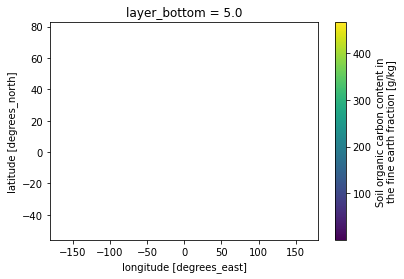

In [5]:
ds.soc.isel(layer_bottom=0).plot() ; 

<xarray.DataArray ()>
array(2.)
<xarray.DataArray 'bdod' (layer_bottom: 6, lat: 3047, lon: 7908)>
[144574056 values with dtype=float64]
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Attributes:
    long_name:     Bulk density of the fine earth fraction
    units:         kg/dm³
    grid_mapping:  spatial_ref
<xarray.DataArray 'cfvo' (layer_bottom: 6, lat: 3047, lon: 7908)>
[144574056 values with dtype=float64]
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Attributes:
    long_name:     Volumetric fraction of coarse fragments (> 2 mm)
    units:         cm3/100cm3 (vol%)
    grid_mapping:  spatial_ref


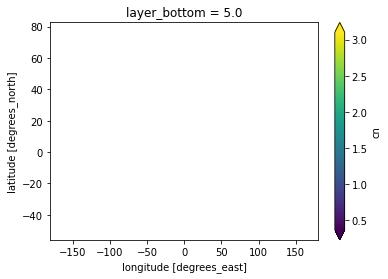

In [6]:
depth = xr.DataArray([0.05,0.1,0.15,0.3,0.4,1.],dims = "layer_bottom", 
                     coords = dict(later_bottom=ds.layer_bottom) )# m
print(sum(depth))
print(ds.bdod)
print(ds.cfvo)
ds['cn'] = ds.soc / ds.nitrogen
ds.cn.isel(layer_bottom=0).plot(robust=True) ;

<xarray.DataArray 'layer_bottom' (layer_bottom: 5)>
array([  5.,  15.,  30.,  60., 100.])
Coordinates:
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0
    later_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0
Attributes:
    axis:       Z
    units:      cm
    long_name:  depth to bottom of soil layer


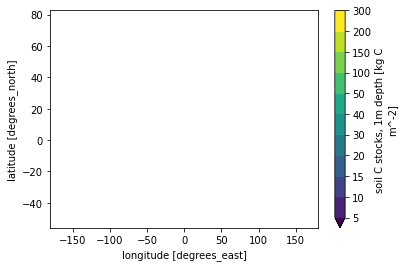

In [7]:
# sum up soil C to 1 m depth
ocd = (ds.ocd * depth).isel(layer_bottom=slice(0,5))
print(ocd.layer_bottom)
ocd = ocd.sum('layer_bottom').load() 
ocd.attrs['long_name'] = 'soil C stocks, 1m depth'
ocd.attrs['units'] = 'kg C m^-2'
levels = [5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 300]
ocd.where(ocd>0).plot(levels=levels, cbar_kwargs={"ticks": levels}) ;

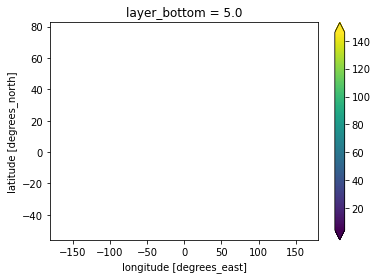

In [8]:
ocd2 = ds.soc*(1-(ds.cfvo/100))*ds.bdod  #convert gC/kg soil to kgC/m2
#ocd2 = ds2.soc*ds2.bdod  #convert gC/kg soil to kgC/m2
ocd2.isel(layer_bottom=0).plot(robust=True) ;

### Regrid 

In [9]:

# open 1 degree file for target coords
fin1 = '/glade/p/cgd/tss/people/wwieder/VernalWindow/et.nc'
ds1 = xr.open_dataset(fin1)

# make target grid
ds_out = xr.Dataset({'lat': (['lat'], ds1.lat),
                     'lon': (['lon'], ds1.lon)})

# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?
gridIn = 'bilinear_3047x7908_192x288_peri.nc'
Regridder = xe.Regridder(ocd, ds_out, 'bilinear',periodic=True, 
                         filename=gridIn, reuse_weights=True)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


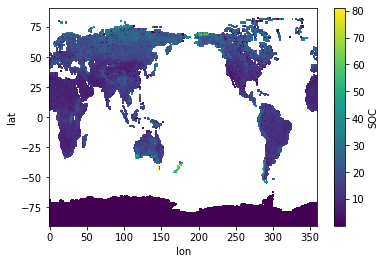

In [65]:
ds_out = Regridder(ocd).compute()
ds_out = ds_out.where(ds1.et.max('time')>0) ;
ds_out = ds_out.where(ds_out>0).rename('SOC')
ds_out.plot();

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


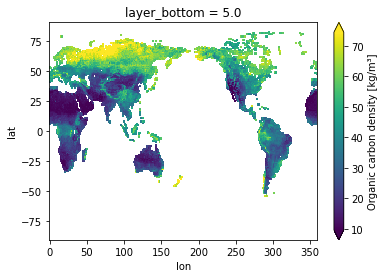

In [66]:
ds_out2 = Regridder(ds.ocd).compute()
ds_out2 = ds_out2.where(ds1.et.max('time')>0) ;
ds_out2 = ds_out2.where(ds_out2>0).rename('ORG_C')
ds_out2.attrs['long_name'] = ds.ocd.attrs['long_name'] 
ds_out2.attrs['units']= ds.ocd.attrs['units'] 

ds_out2.isel(layer_bottom=0).plot(robust=True);


In [67]:
fin = '/glade/p/cgd/tss/people/wwieder/clm5_FACE_r270/pft_effects/'
fin = fin + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist_FACE.clm2.h0_2014_mean.nc'
ds2 = xr.open_dataset(fin)

In [68]:
ds_out['area'] = ds2.area
ds_out['landfrac'] = ds2.landfrac
ds_out.attrs=ocd.attrs
SOCtot = (ds_out * ds_out.area * ds_out.landfrac * 1e6).sum()*1e-12 # 
SOCtot

<xarray.DataArray ()>
array(1689.42226506)

In [69]:
## Write out .nc file
fout = '/glade/p/cgd/tss/people/wwieder/SoilGrids/ncMerged/SoilGrids_1m_1degree.nc'
ds_out.to_netcdf(fout)
print('wrote '+fout)

wrote /glade/p/cgd/tss/people/wwieder/SoilGrids/ncMerged/SoilGrids_1m_1degree.nc


In [70]:
ds_out2['area'] = ds2.area
ds_out2['landfrac'] = ds2.landfrac
SOCtot = ((ds_out2*depth).sum('layer_bottom') * ds_out.area * ds_out.landfrac * 1e6).sum()*1e-12 # 
SOCtot


<xarray.DataArray ()>
array(2459.00581013)

In [71]:
## Write out .nc file
fout2 = '/glade/p/cgd/tss/people/wwieder/SoilGrids/ncMerged/SoilGrids_vr_1degree.nc'
ds_out2.to_netcdf(fout2)
print('wrote '+fout2)

wrote /glade/p/cgd/tss/people/wwieder/SoilGrids/ncMerged/SoilGrids_vr_1degree.nc


### compare with ORGANIC from current CLM surface dataset

In [73]:
ds_out2

<xarray.DataArray 'ORG_C' (layer_bottom: 6, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 ...
    landfrac      (lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear
    long_name:      Organic carbon density
    units:          kg/m³

In [ ]:
surf = xr.open_dataset('/glade/work/wwieder/surfdata_0.9x1.25_simyr2000_c110921.nc')
surf = surf.where(ds1.et.max('time')>0)
surf = surf.where(surf.ORGANIC>0)
surf.ORGANIC.isel(nlevsoi=0).plot()


In [74]:
x1 = surf.ORGANIC.isel(nlevsoi=0).mean('lsmlon')
#convert to gOM, assumed carbon content 0.58 gC per gOM

x2 = (ds_out2.isel(layer_bottom=0).mean('lon')) / 0.58
#x2 = x2.to_array().squeeze()
surf.ORGANIC

<xarray.DataArray 'ORGANIC' (nlevsoi: 10, lsmlat: 192, lsmlon: 288)>
[552960 values with dtype=float64]
Dimensions without coordinates: nlevsoi, lsmlat, lsmlon
Attributes:
    long_name:  organic matter density at soil levels
    units:      kg/m3 (assumed carbon content 0.58 gC per gOM)

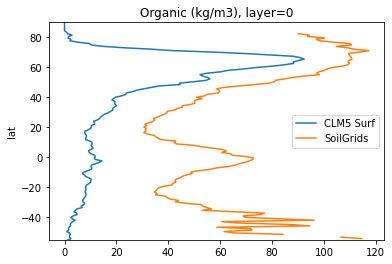

In [75]:
plt.plot(x1, x2.lat)
plt.plot(x2, x2.lat)
plt.ylim([-55, 90])
plt.ylabel('lat')
plt.title('Organic (kg/m3), layer=0') 
plt.legend(['CLM5 Surf','SoilGrids'])

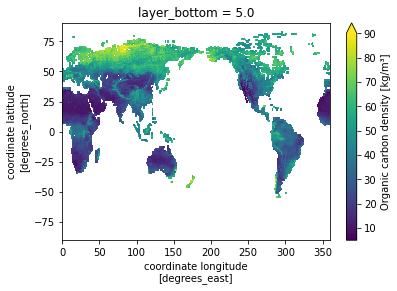

In [80]:
ds_out2.isel(layer_bottom=0).plot(vmin=5,vmax=90)

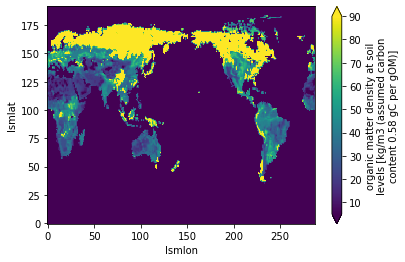

In [79]:
surf['ORGANIC'] = surf.ORGANIC.where(surf.ORGANIC>0)
surf.ORGANIC.isel(nlevsoi=0).plot(vmin=5,vmax=90)